<a href="https://colab.research.google.com/github/rbutti/machine-learning-cohort/blob/main/DataDazzlers_DineOracle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Imports

In [1]:
import os
import warnings
import itertools
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
warnings.filterwarnings('ignore')

In [2]:
#Dataframe and numerical library
import pandas as pd 
pd.set_option('display.max_columns', None)
!pip install pandas_profiling 
import pandas_profiling as pp
import numpy as np
from pandas_profiling import ProfileReport

# JSON
from pandas.io.json import json_normalize

#Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

# SQLite
import sqlite3
import ipywidgets as widgets
from IPython.display import display

# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif

#Machine Learming Model
#Metrics
from sklearn.metrics import mutual_info_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

#Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

#Linear Model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

#Ensemble
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#Others
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

#Hyper parameter
from sklearn import neighbors, datasets, model_selection

# XGBoost
import xgboost as xgb
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

#Neural Network
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from numpy import argmax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.9/345.9 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 53.4 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=9d45a419092f77ec563060e06f19fd2932fdb88fe97bbb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data Import

In [3]:
#STEP 1: Import large dataset using opendatasets
if not os.path.exists('yelp-business-dataset'):
  print("Loading Keys")
  kaggle_key = 'ravikiranbutti'
  kaggle_value = '117268fa41345f39e5baeda66733a0c7'
  os.environ['KAGGLE_USERNAME'] = kaggle_key
  os.environ['KAGGLE_KEY'] = kaggle_value
  !mkdir -p /root/.kaggle
  with open('/root/.kaggle/kaggle.json', 'w') as kaggle_file:
    kaggle_file.write('{"username":"' + kaggle_key + '","key":"' + kaggle_value + '"}')

  print("Loading Data")
  !pip install kaggle
  !kaggle datasets download ravikiranbutti/yelp-business-dataset
  !unzip yelp-business-dataset.zip -d 'yelp-business-dataset'
  !rm yelp-business-dataset.zip

Loading Keys
Loading Data
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 20.8M/20.8M [00:00<00:00, 64.2MB/s]
100% 20.8M/20.8M [00:00<00:00, 63.8MB/s]
Archive:  yelp-business-dataset.zip
  inflating: yelp-business-dataset/yelp_academic_dataset_business.json  


In [4]:
#STEP 2: Load Business using chunk processing
business_chunks = pd.read_json("yelp-business-dataset/yelp_academic_dataset_business.json", lines=True, chunksize=1000000)
business = pd.concat(business_chunks) 

In [5]:
#Print information
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


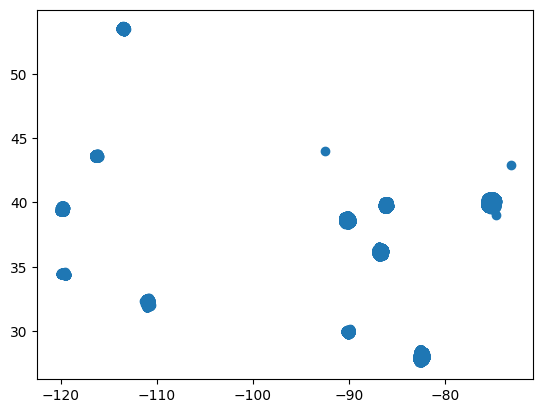

In [6]:
import matplotlib.pyplot as plt
plt.scatter(x=business['longitude'], y=business['latitude'])
plt.show()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 81.4 MB/s eta 0:00:00


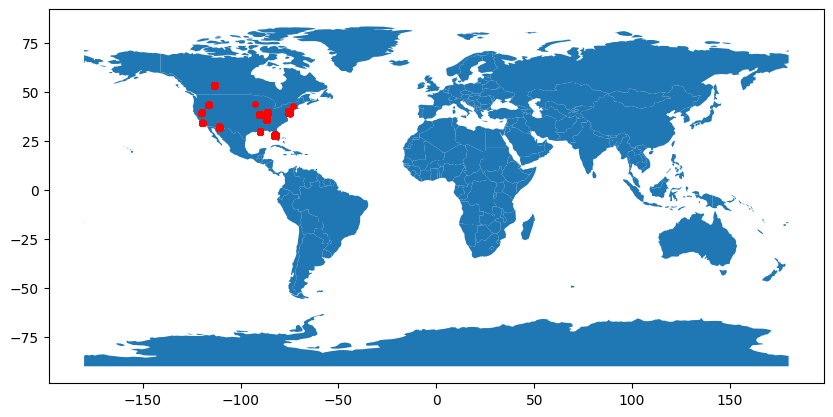

In [7]:
!pip install geopandas
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

df = business

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

# Data Exploration

In [8]:
#Check for duplicates fails - need to normalize
# business.duplicated().sum()

In [9]:
# Checking for Null Values -- Attributes and Hours have null values
business.isnull().sum()

business_id         0
name                0
address             0
city                0
state               0
postal_code         0
latitude            0
longitude           0
stars               0
review_count        0
is_open             0
attributes      13744
categories        103
hours           23223
dtype: int64

In [10]:
# Checking for Null Values -- Attributes and Hours have null values
business.isnull().sum()

business_id         0
name                0
address             0
city                0
state               0
postal_code         0
latitude            0
longitude           0
stars               0
review_count        0
is_open             0
attributes      13744
categories        103
hours           23223
dtype: int64

## Univariate analysis

In [11]:
# Univariate analysis of continuous variables
business.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,150346.0,36.671150,5.872759,27.555127,32.187293,38.777413,39.954036,53.679197
longitude,150346.0,-89.357339,14.918502,-120.095137,-90.357810,-86.121179,-75.421542,-73.200457
stars,150346.0,3.596724,0.974421,1.000000,3.000000,3.500000,4.500000,5.000000
review_count,150346.0,44.866561,121.120136,5.000000,8.000000,15.000000,37.000000,7568.000000
is_open,150346.0,0.796150,0.402860,0.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
#Check how many unique states are there
business['state'].value_counts()

PA     34039
FL     26330
TN     12056
IN     11247
MO     10913
LA      9924
AZ      9912
NJ      8536
NV      7715
AB      5573
CA      5203
ID      4467
DE      2265
IL      2145
TX         4
CO         3
WA         2
HI         2
MA         2
NC         1
UT         1
MT         1
MI         1
SD         1
XMS        1
VI         1
VT         1
Name: state, dtype: int64

In [13]:
business['is_open'].value_counts()

1    119698
0     30648
Name: is_open, dtype: int64

In [14]:
business['review_count'].value_counts()

5       14921
6       11673
7        9594
8        8040
9        6875
        ...  
2417        1
1001        1
2473        1
1583        1
754         1
Name: review_count, Length: 1158, dtype: int64

<Axes: xlabel='state', ylabel='count'>

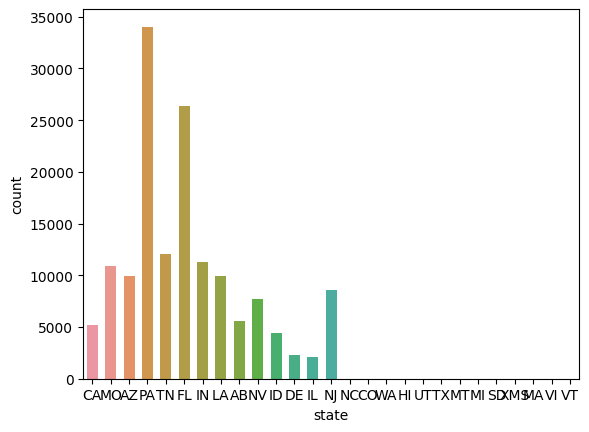

In [15]:
#Plot the states categorical variable
sns.countplot(x="state", data=business, width = 0.6)
# Data is concentrated within afew states - rest can be dropped

<Axes: xlabel='state', ylabel='count'>

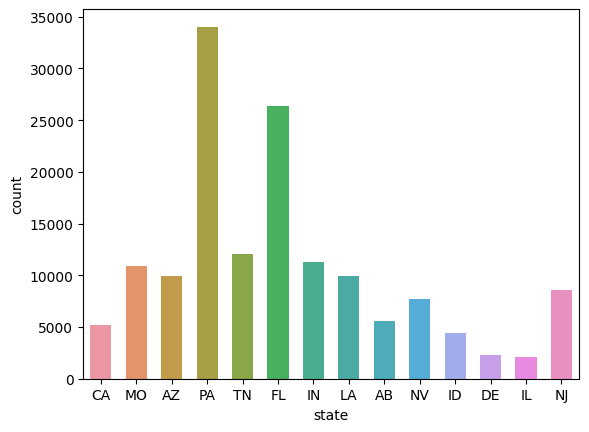

In [16]:
# Group the dataframe by state and count the number of restaurants in each state
state_counts = business \
              .groupby('state') \
              .size() \
              .reset_index(name='restaurant_count')

# Filter the states where the count of restaurants is less than 500
filtered_states = state_counts[state_counts['restaurant_count'] >= 500]

# Return the filtered dataframe with only the states that meet the criteria
business = business[business['state'].isin(filtered_states['state'])]

sns.countplot(x="state", data=business, width = 0.6)

<Axes: xlabel='stars', ylabel='count'>

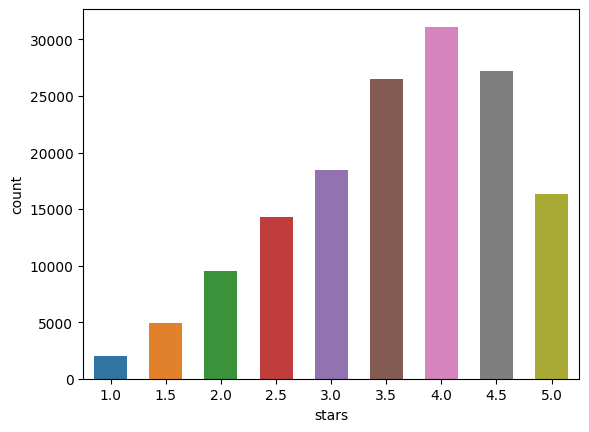

In [17]:
#Plot the 'stars'  categorical variable
sns.countplot(x="stars", data=business, width = 0.6)
# We see very few values with 1-2 stars rating

We see very few values with stars = 1 or 1.5

<Axes: xlabel='review_count', ylabel='Count'>

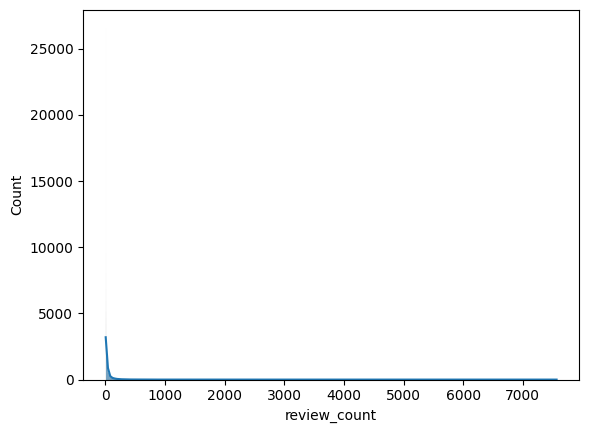

In [18]:
# Plot distribution of review_count
sns.histplot(data=business.review_count, kde=True)

<Axes: xlabel='review_count', ylabel='Count'>

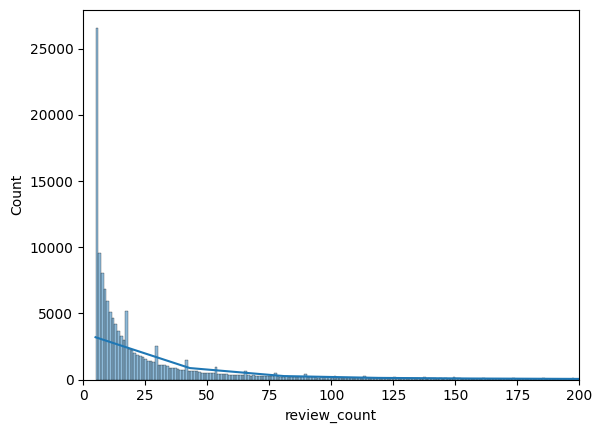

In [19]:
#Re-plot after adjusting limit

plt.xlim(0, 200)
sns.histplot(data=business.review_count, kde=True)

We see very few rows with review count > 75, we can remove those rows with no impact

## Bivariate Analysis

In [20]:
#Bivariate Analysis of Continuous Variables
business.corr()

# No string correlation observed here

,latitude,longitude,stars,review_count,is_open
latitude,1.000000,-0.135804,-0.036313,-0.046298,-0.016788
longitude,-0.135804,1.000000,-0.056101,-0.008818,-0.014307
stars,-0.036313,-0.056101,1.000000,0.059876,0.045025
review_count,-0.046298,-0.008818,0.059876,1.000000,0.029649
is_open,-0.016788,-0.014307,0.045025,0.029649,1.000000


<Axes: xlabel='review_count', ylabel='is_open'>

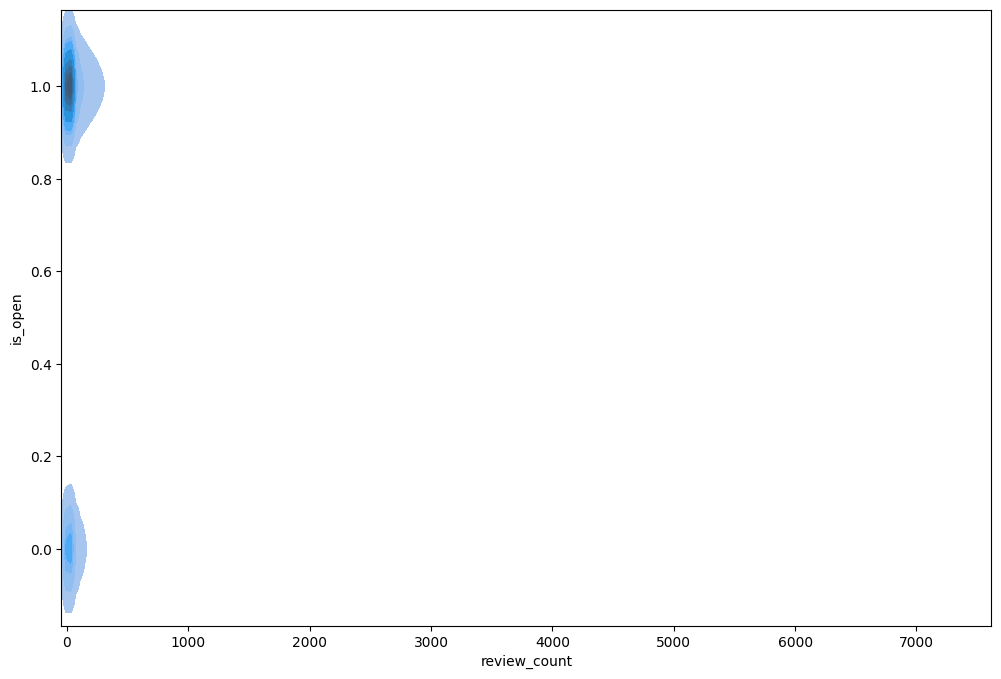

In [21]:
# Plot KDE plots of continuous variables 
plt.figure(figsize=(12,8))
sns.kdeplot(data=business,x='review_count', y='is_open',fill=True)

Review count has neglible impact on target variable is_open

In [22]:
# 'stars' is a categorical variable
# Change type to object
new_business = business.astype({'stars':'object'})
new_business.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150325 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150325 non-null  object 
 1   name          150325 non-null  object 
 2   address       150325 non-null  object 
 3   city          150325 non-null  object 
 4   state         150325 non-null  object 
 5   postal_code   150325 non-null  object 
 6   latitude      150325 non-null  float64
 7   longitude     150325 non-null  float64
 8   stars         150325 non-null  object 
 9   review_count  150325 non-null  int64  
 10  is_open       150325 non-null  int64  
 11  attributes    136584 non-null  object 
 12  categories    150222 non-null  object 
 13  hours         127110 non-null  object 
dtypes: float64(2), int64(2), object(10)
memory usage: 17.2+ MB


<Axes: >

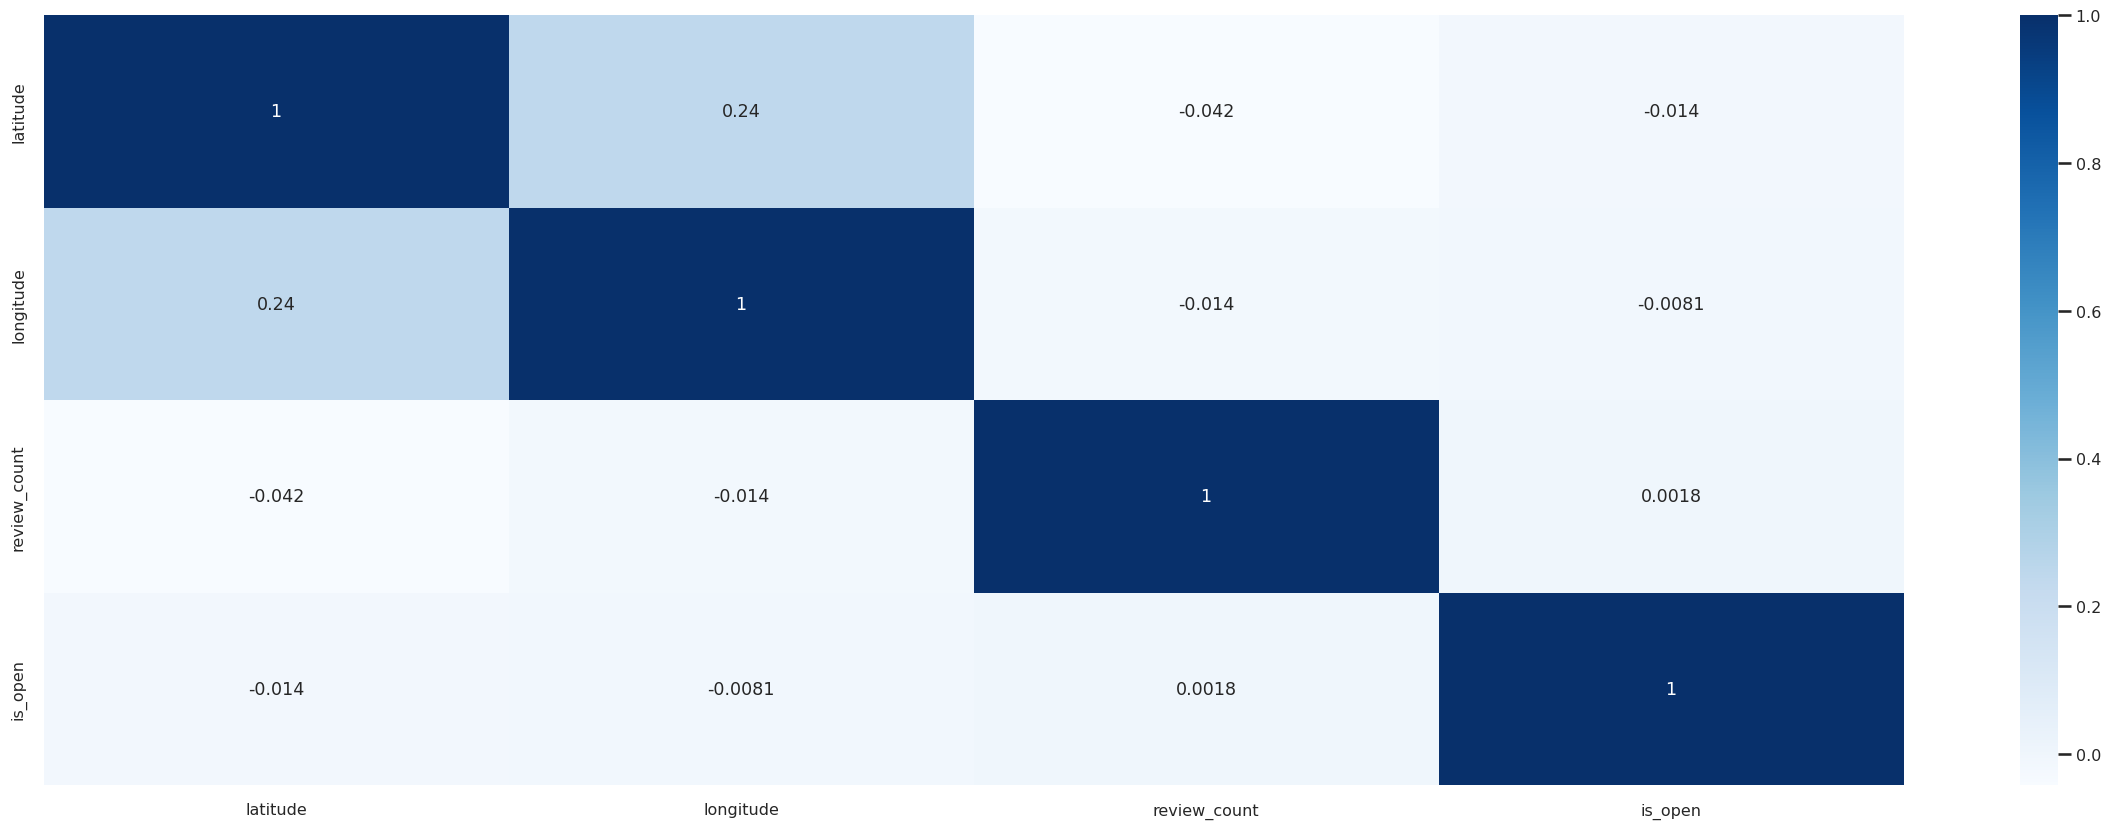

In [23]:
#Heatmap
sns.set(rc={'figure.figsize':(30,10)})
sns.set_context("talk", font_scale=0.7)
sns.heatmap(new_business.iloc[:,1:].corr(method='spearman'), cmap="Blues", annot=True)

Variables don't show any significant correlation

In [24]:
# report = ProfileReport(new_business)
# report

# Data Cleaning


In [25]:
#Select only the restaurant
business = business[business['categories'].str.contains('Restaurants', na=False)]
business.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 52263 entries, 3 to 150340
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   52263 non-null  object 
 1   name          52263 non-null  object 
 2   address       52263 non-null  object 
 3   city          52263 non-null  object 
 4   state         52263 non-null  object 
 5   postal_code   52263 non-null  object 
 6   latitude      52263 non-null  float64
 7   longitude     52263 non-null  float64
 8   stars         52263 non-null  float64
 9   review_count  52263 non-null  int64  
 10  is_open       52263 non-null  int64  
 11  attributes    51698 non-null  object 
 12  categories    52263 non-null  object 
 13  hours         44988 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 6.0+ MB


In [26]:
# Drop unimportant columns
business = business.drop(['business_id','name','address','latitude','longitude','hours','review_count','stars'], axis=1)
business.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52263 entries, 3 to 150340
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   city         52263 non-null  object
 1   state        52263 non-null  object
 2   postal_code  52263 non-null  object
 3   is_open      52263 non-null  int64 
 4   attributes   51698 non-null  object
 5   categories   52263 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.8+ MB


In [27]:
business.head()

,city,state,postal_code,is_open,attributes,categories
3,Philadelphia,PA,19107,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
5,Ashland City,TN,37015,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea..."
8,Affton,MO,63123,0,"{'Caters': 'True', 'Alcohol': 'u'full_bar'', '...","Pubs, Restaurants, Italian, Bars, American (Tr..."
9,Nashville,TN,37207,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,..."
11,Tampa Bay,FL,33602,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks"


In [28]:
#Drop rows of states with low data as seen above. Excluding states with under 2000 rows 
df_s = pd.DataFrame([business['state'].value_counts() > 2000]).T

df_s = df_s[df_s.state == True]

df_s['state'] = df_s.index
states_list = df_s['state'].tolist()
states_list

['PA', 'FL', 'TN', 'MO', 'IN', 'LA', 'NJ', 'AZ', 'AB']

In [29]:
#Drop rows with low review_count


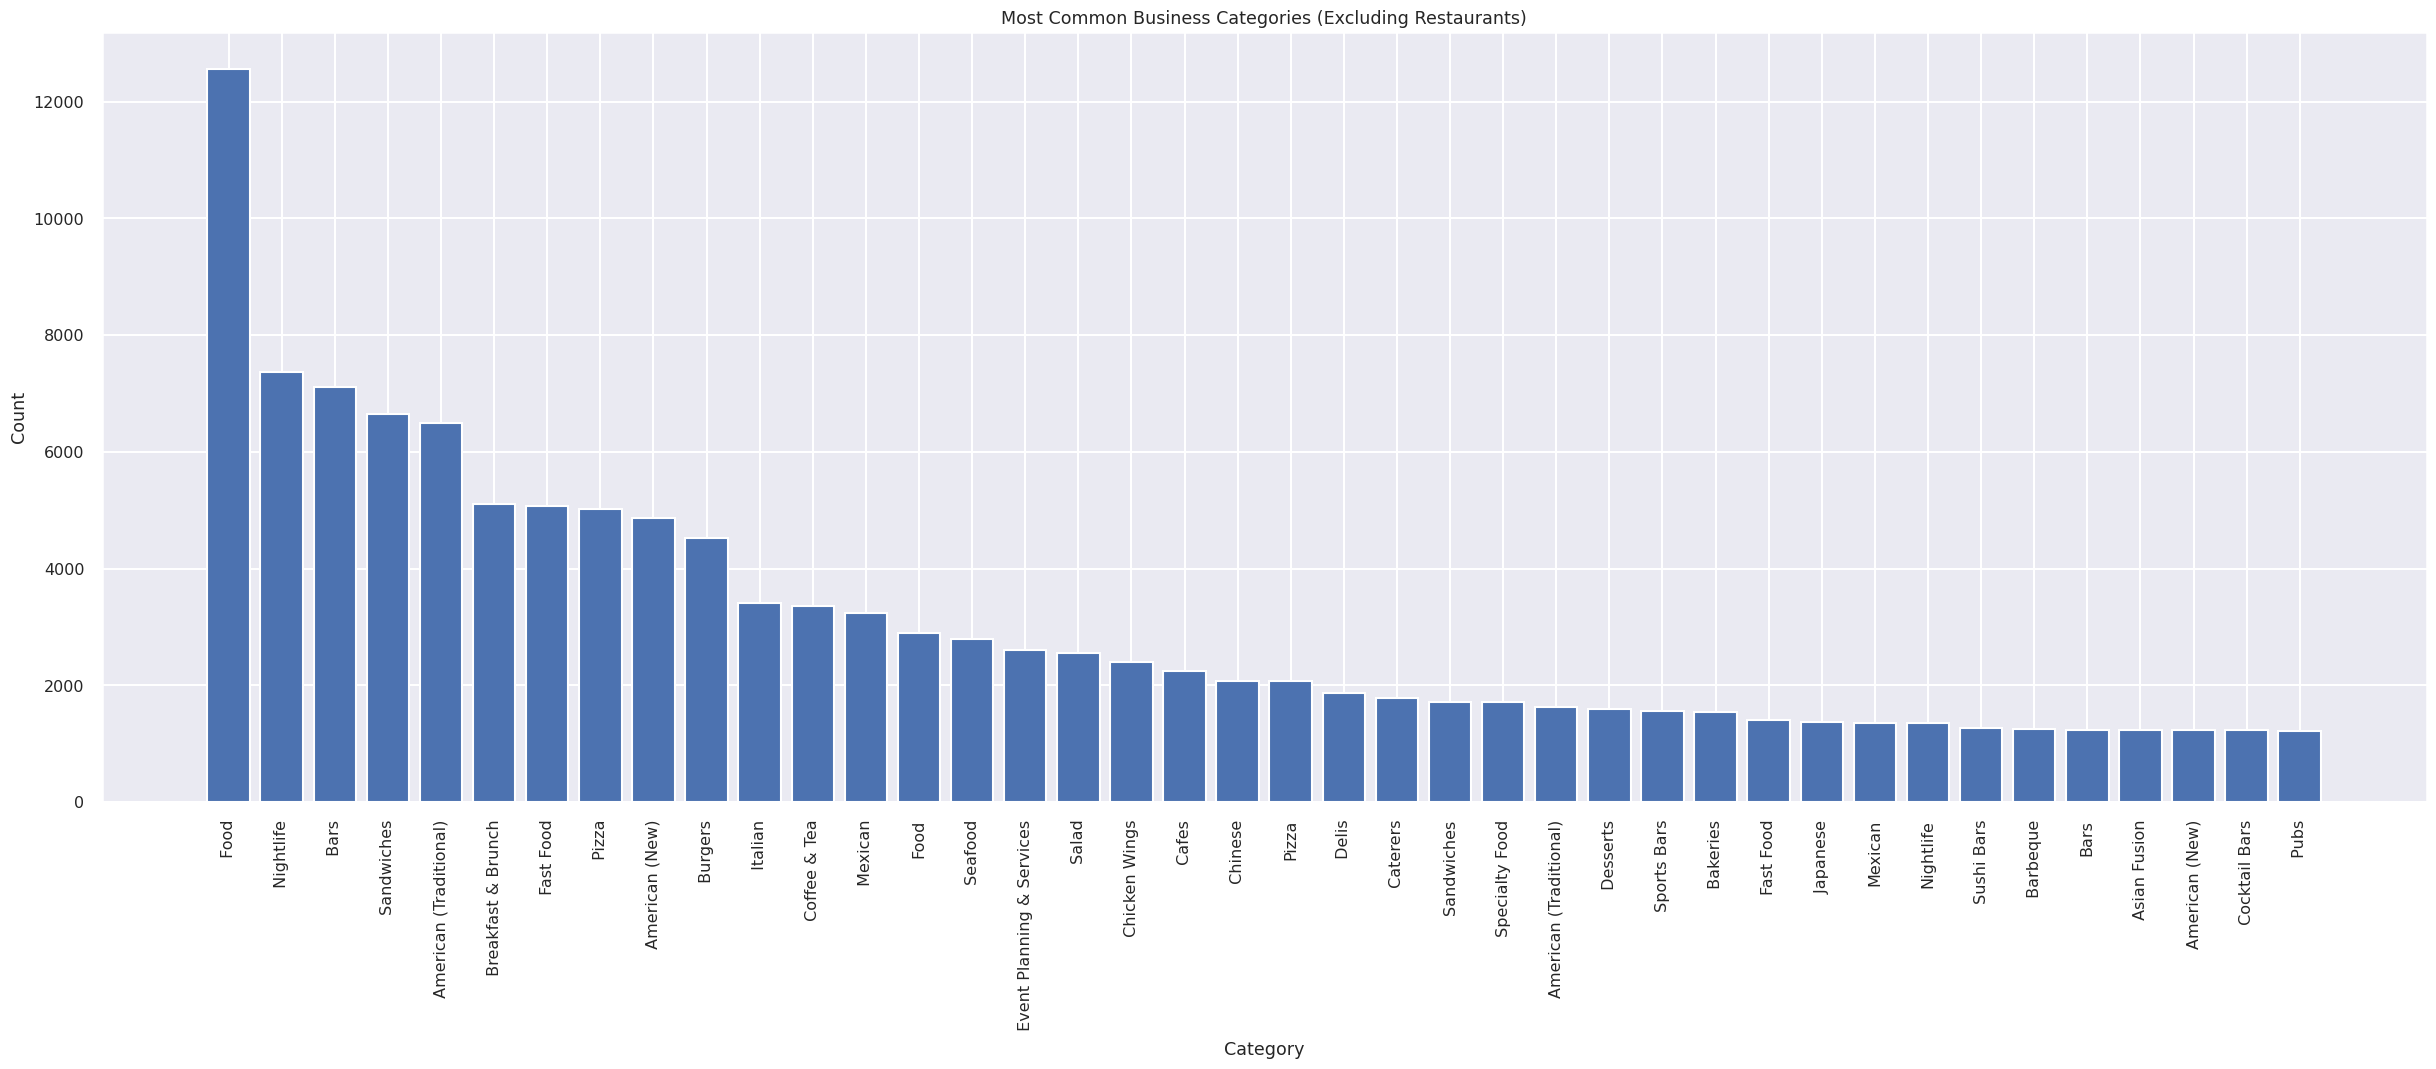

In [30]:
# Create a dictionary to store the count of each business category
Categories = {}

# Loop through each row in the 'categories' column of the dataframe
for x in business.categories:
    all_categories = x.split(';')  # Split on semicolons
    all_categories = [c.split(',') for c in all_categories]  # Split on commas
    all_categories = [c for sublist in all_categories for c in sublist if c.lower() != ' restaurants']  # Flatten and filter list of lists

    # Loop through each category in the current row
    for cat in all_categories:
        if cat not in Categories:
            Categories[cat] = 1
        else:
            Categories[cat] += 1

# Sort the categories by count in descending order and select the top 25
All_categories = list(Categories.keys())
Cat_list = [[x, Categories[x]] for x in All_categories if x.lower() != 'restaurants']
Cat_list = sorted(Cat_list, key=lambda x: x[1], reverse=True)[:40]

# Create a bar graph of the top 40 categories
plt.bar(range(len(Cat_list)), [x[1] for x in Cat_list], align="center")
plt.xticks(range(len(Cat_list)), [x[0] for x in Cat_list], rotation="vertical")
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Most Common Business Categories (Excluding Restaurants)")
plt.show()

# Data Preprocessing

## Business Attributes



In [43]:
# Use json_normalize() function to normalize the JSON column
normalized_df = json_normalize(business['attributes'])

# count the number of non-null values for each column
counts = normalized_df.notna().sum()

# filter out columns with less than 10000 non-null values
normalized_df = normalized_df.loc[:, counts >= 10000]

# Merge the new DataFrame with the original DataFrame and fill missing values with 0
business_normalized = pd.concat([business, normalized_df], axis=1)
business_normalized.fillna(0, inplace=True)

# Set value to 1 if present and 0 if absent
business_normalized[normalized_df.columns] = business_normalized[normalized_df.columns].applymap(lambda x: 1 if x != 0 else 0)

#drop attributes column
business_normalized.drop(columns=['attributes'], inplace=True)

business_normalized.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 86401 entries, 3 to 52262
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   city                        86401 non-null  object 
 1   state                       86401 non-null  object 
 2   postal_code                 86401 non-null  object 
 3   is_open                     86401 non-null  float64
 4   categories                  86401 non-null  object 
 5   RestaurantsDelivery         86401 non-null  int64  
 6   OutdoorSeating              86401 non-null  int64  
 7   BusinessAcceptsCreditCards  86401 non-null  int64  
 8   BusinessParking             86401 non-null  int64  
 9   BikeParking                 86401 non-null  int64  
 10  RestaurantsPriceRange2      86401 non-null  int64  
 11  RestaurantsTakeOut          86401 non-null  int64  
 12  WiFi                        86401 non-null  int64  
 13  Alcohol                     864

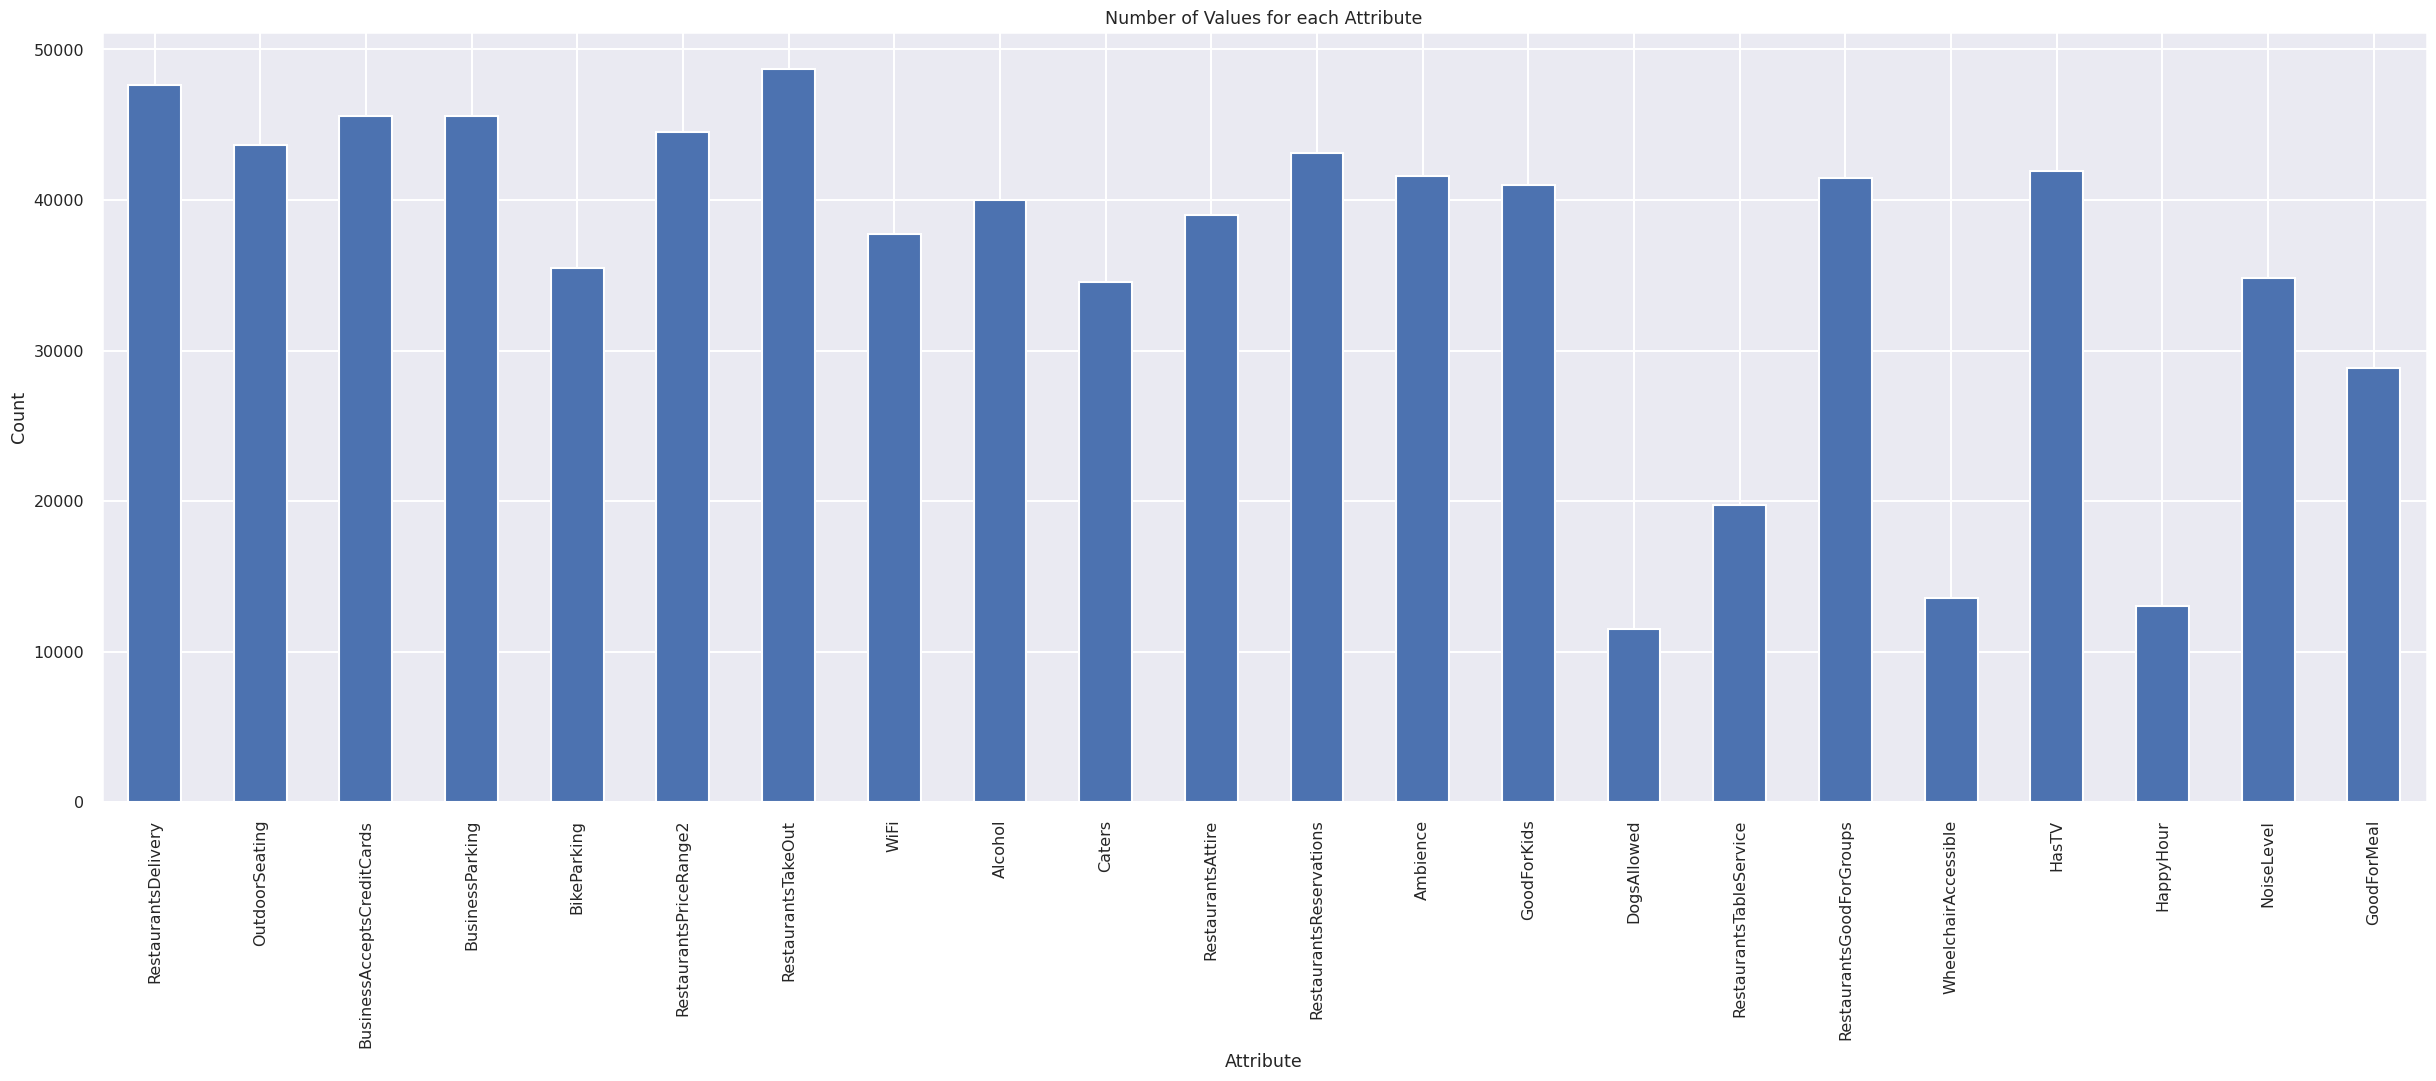

In [32]:
# count the number of values for each attribute
count_series = normalized_df.notna().sum()

# create a bar plot of the counts
count_series.plot(kind='bar')

# set the plot title and axis labels
plt.title('Number of Values for each Attribute')
plt.xlabel('Attribute')
plt.ylabel('Count')

# show the plot
plt.show()

In [33]:
business_normalized.head()

,city,state,postal_code,is_open,categories,RestaurantsDelivery,OutdoorSeating,BusinessAcceptsCreditCards,BusinessParking,BikeParking,RestaurantsPriceRange2,RestaurantsTakeOut,WiFi,Alcohol,Caters,RestaurantsAttire,RestaurantsReservations,Ambience,GoodForKids,DogsAllowed,RestaurantsTableService,RestaurantsGoodForGroups,WheelchairAccessible,HasTV,HappyHour,NoiseLevel,GoodForMeal
3,Philadelphia,PA,19107,1.0,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,0
5,Ashland City,TN,37015,1.0,"Burgers, Fast Food, Sandwiches, Food, Ice Crea...",1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,1,0,1,0,0,1
8,Affton,MO,63123,0.0,"Pubs, Restaurants, Italian, Bars, American (Tr...",1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,0,1,1
9,Nashville,TN,37207,1.0,"Ice Cream & Frozen Yogurt, Fast Food, Burgers,...",1,1,0,1,0,1,1,1,1,1,1,1,1,1,0,0,1,0,1,0,1,0
11,Tampa Bay,FL,33602,1.0,"Vietnamese, Food, Restaurants, Food Trucks",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1


### Feature Selection

In [34]:
#  #NOTE: Add to sample it because of memory restrictions
# business_feature_selection = business_normalized.sample(n=25000, random_state=42)

# # Separate the features and the target variable
# X = business_feature_selection.drop(['is_open','categories'], axis=1)
# y = business_feature_selection['is_open']

# # Assume df is the original dataframe with non-numerical columns
# # Get all non-numerical columns and perform one-hot encoding
# non_numeric_cols = list(business_feature_selection.select_dtypes(exclude=['number', 'bool']).columns)
# one_hot_encoded = pd.get_dummies(business_feature_selection[non_numeric_cols])

# # Combine one-hot encoded columns with numerical columns
# numerical_cols = list(business_feature_selection.select_dtypes(include=['number', 'bool']).columns)
# X = pd.concat([business_feature_selection[numerical_cols], one_hot_encoded], axis=1)

# # Select the top 10 features using f_classif score
# selector = SelectKBest(score_func=f_classif, k=50)
# X_new = selector.fit_transform(X, y)

# # Get the selected feature names
# selected_features = X.columns[selector.get_support()]

# # Print the selected feature names
# print('Selected features:', list(selected_features))

In [35]:
# #Data cleaning, remove columns already in the business set
# selected_features = {item for item in selected_features if not item.startswith('categories')}
# selected_features = {item for item in selected_features if not item.startswith('city_')}
# selected_features = {item for item in selected_features if not item.startswith('state_')}
# selected_features = {item for item in selected_features if not item.startswith('postal_code_')}
# index = pd.Index(selected_features)

# # select only columns in the Index object
# business_normalized = pd.concat([business_normalized['categories'], business_normalized.loc[:, index]], axis=1)
# business_normalized.info()


In [36]:
business_normalized.head()

,city,state,postal_code,is_open,categories,RestaurantsDelivery,OutdoorSeating,BusinessAcceptsCreditCards,BusinessParking,BikeParking,RestaurantsPriceRange2,RestaurantsTakeOut,WiFi,Alcohol,Caters,RestaurantsAttire,RestaurantsReservations,Ambience,GoodForKids,DogsAllowed,RestaurantsTableService,RestaurantsGoodForGroups,WheelchairAccessible,HasTV,HappyHour,NoiseLevel,GoodForMeal
3,Philadelphia,PA,19107,1.0,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,0
5,Ashland City,TN,37015,1.0,"Burgers, Fast Food, Sandwiches, Food, Ice Crea...",1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,1,0,1,0,0,1
8,Affton,MO,63123,0.0,"Pubs, Restaurants, Italian, Bars, American (Tr...",1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,0,1,1
9,Nashville,TN,37207,1.0,"Ice Cream & Frozen Yogurt, Fast Food, Burgers,...",1,1,0,1,0,1,1,1,1,1,1,1,1,1,0,0,1,0,1,0,1,0
11,Tampa Bay,FL,33602,1.0,"Vietnamese, Food, Restaurants, Food Trucks",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1


## Categories

In [44]:
# assuming you have loaded the Yelp dataset into a dataframe called "yelp_df"

# normalize the "categories" column
categories_df = business_normalized['categories'].str.get_dummies(sep=',')

# Remove leading and trailing spaces from the new columns
# categories_df = categories_df.apply(lambda x: x.str.strip() if isinstance(x, str) else x)

# update the column names
new_col_names = ['cat_' + str(col).strip() for col in categories_df.columns]
categories_df.columns = new_col_names

# get the duplicated columns
duplicate_cols = categories_df.columns[categories_df.columns.duplicated()]

# select only the non-duplicate columns and assign them back to the DataFrame
categories_df = categories_df.loc[:, ~categories_df.columns.duplicated()]

# count the number of occurrences for each category
category_counts = categories_df.sum()

# select only the categories with more than 2000 occurrences
selected_categories = category_counts[category_counts > 2000].index

# filter the categories dataframe to keep only the selected categories
selected_categories_df = categories_df[selected_categories]

# create a new dataframe with the binary values for each category
binary_categories_df = (selected_categories_df > 0).astype(int)

# concatenate the new dataframe with the original dataframe
business_normalized = pd.concat([business_normalized, binary_categories_df], axis=1)

#ensure column names are cleaned
# business_normalized = business_normalized.rename(columns=lambda x: x.strip() if x[0]==' ' else x)

# print the resulting dataframe
business_normalized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86401 entries, 3 to 52262
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   city                           86401 non-null  object 
 1   state                          86401 non-null  object 
 2   postal_code                    86401 non-null  object 
 3   is_open                        86401 non-null  float64
 4   categories                     86401 non-null  object 
 5   RestaurantsDelivery            86401 non-null  int64  
 6   OutdoorSeating                 86401 non-null  int64  
 7   BusinessAcceptsCreditCards     86401 non-null  int64  
 8   BusinessParking                86401 non-null  int64  
 9   BikeParking                    86401 non-null  int64  
 10  RestaurantsPriceRange2         86401 non-null  int64  
 11  RestaurantsTakeOut             86401 non-null  int64  
 12  WiFi                           86401 non-null 

In [45]:
business_normalized.head()

,city,state,postal_code,is_open,categories,RestaurantsDelivery,OutdoorSeating,BusinessAcceptsCreditCards,BusinessParking,BikeParking,RestaurantsPriceRange2,RestaurantsTakeOut,WiFi,Alcohol,Caters,RestaurantsAttire,RestaurantsReservations,Ambience,GoodForKids,DogsAllowed,RestaurantsTableService,RestaurantsGoodForGroups,WheelchairAccessible,HasTV,HappyHour,NoiseLevel,GoodForMeal,cat_American (New),cat_American (Traditional),cat_Bars,cat_Breakfast & Brunch,cat_Burgers,cat_Cafes,cat_Chicken Wings,cat_Chinese,cat_Coffee & Tea,cat_Event Planning & Services,cat_Fast Food,cat_Food,cat_Italian,cat_Mexican,cat_Nightlife,cat_Pizza,cat_Restaurants,cat_Salad,cat_Sandwiches,cat_Seafood,cat_0
3,Philadelphia,PA,19107,1.0,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
5,Ashland City,TN,37015,1.0,"Burgers, Fast Food, Sandwiches, Food, Ice Crea...",1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0
8,Affton,MO,63123,0.0,"Pubs, Restaurants, Italian, Bars, American (Tr...",1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0
9,Nashville,TN,37207,1.0,"Ice Cream & Frozen Yogurt, Fast Food, Burgers,...",1,1,0,1,0,1,1,1,1,1,1,1,1,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0
11,Tampa Bay,FL,33602,1.0,"Vietnamese, Food, Restaurants, Food Trucks",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0


In [46]:
#drop categories column
business_normalized.drop(columns=['categories','cat_Restaurants'], inplace=True)

business_normalized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86401 entries, 3 to 52262
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   city                           86401 non-null  object 
 1   state                          86401 non-null  object 
 2   postal_code                    86401 non-null  object 
 3   is_open                        86401 non-null  float64
 4   RestaurantsDelivery            86401 non-null  int64  
 5   OutdoorSeating                 86401 non-null  int64  
 6   BusinessAcceptsCreditCards     86401 non-null  int64  
 7   BusinessParking                86401 non-null  int64  
 8   BikeParking                    86401 non-null  int64  
 9   RestaurantsPriceRange2         86401 non-null  int64  
 10  RestaurantsTakeOut             86401 non-null  int64  
 11  WiFi                           86401 non-null  int64  
 12  Alcohol                        86401 non-null 

In [47]:
business_normalized['is_open'] = business_normalized['is_open'].astype(int)

In [48]:
print(business_normalized.columns.tolist())

['city', 'state', 'postal_code', 'is_open', 'RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'WiFi', 'Alcohol', 'Caters', 'RestaurantsAttire', 'RestaurantsReservations', 'Ambience', 'GoodForKids', 'DogsAllowed', 'RestaurantsTableService', 'RestaurantsGoodForGroups', 'WheelchairAccessible', 'HasTV', 'HappyHour', 'NoiseLevel', 'GoodForMeal', 'cat_American (New)', 'cat_American (Traditional)', 'cat_Bars', 'cat_Breakfast & Brunch', 'cat_Burgers', 'cat_Cafes', 'cat_Chicken Wings', 'cat_Chinese', 'cat_Coffee & Tea', 'cat_Event Planning & Services', 'cat_Fast Food', 'cat_Food', 'cat_Italian', 'cat_Mexican', 'cat_Nightlife', 'cat_Pizza', 'cat_Salad', 'cat_Sandwiches', 'cat_Seafood', 'cat_0']


In [49]:
business_normalized.head()

,city,state,postal_code,is_open,RestaurantsDelivery,OutdoorSeating,BusinessAcceptsCreditCards,BusinessParking,BikeParking,RestaurantsPriceRange2,RestaurantsTakeOut,WiFi,Alcohol,Caters,RestaurantsAttire,RestaurantsReservations,Ambience,GoodForKids,DogsAllowed,RestaurantsTableService,RestaurantsGoodForGroups,WheelchairAccessible,HasTV,HappyHour,NoiseLevel,GoodForMeal,cat_American (New),cat_American (Traditional),cat_Bars,cat_Breakfast & Brunch,cat_Burgers,cat_Cafes,cat_Chicken Wings,cat_Chinese,cat_Coffee & Tea,cat_Event Planning & Services,cat_Fast Food,cat_Food,cat_Italian,cat_Mexican,cat_Nightlife,cat_Pizza,cat_Salad,cat_Sandwiches,cat_Seafood,cat_0
3,Philadelphia,PA,19107,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
5,Ashland City,TN,37015,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0
8,Affton,MO,63123,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
9,Nashville,TN,37207,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
11,Tampa Bay,FL,33602,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


### Feature Selection


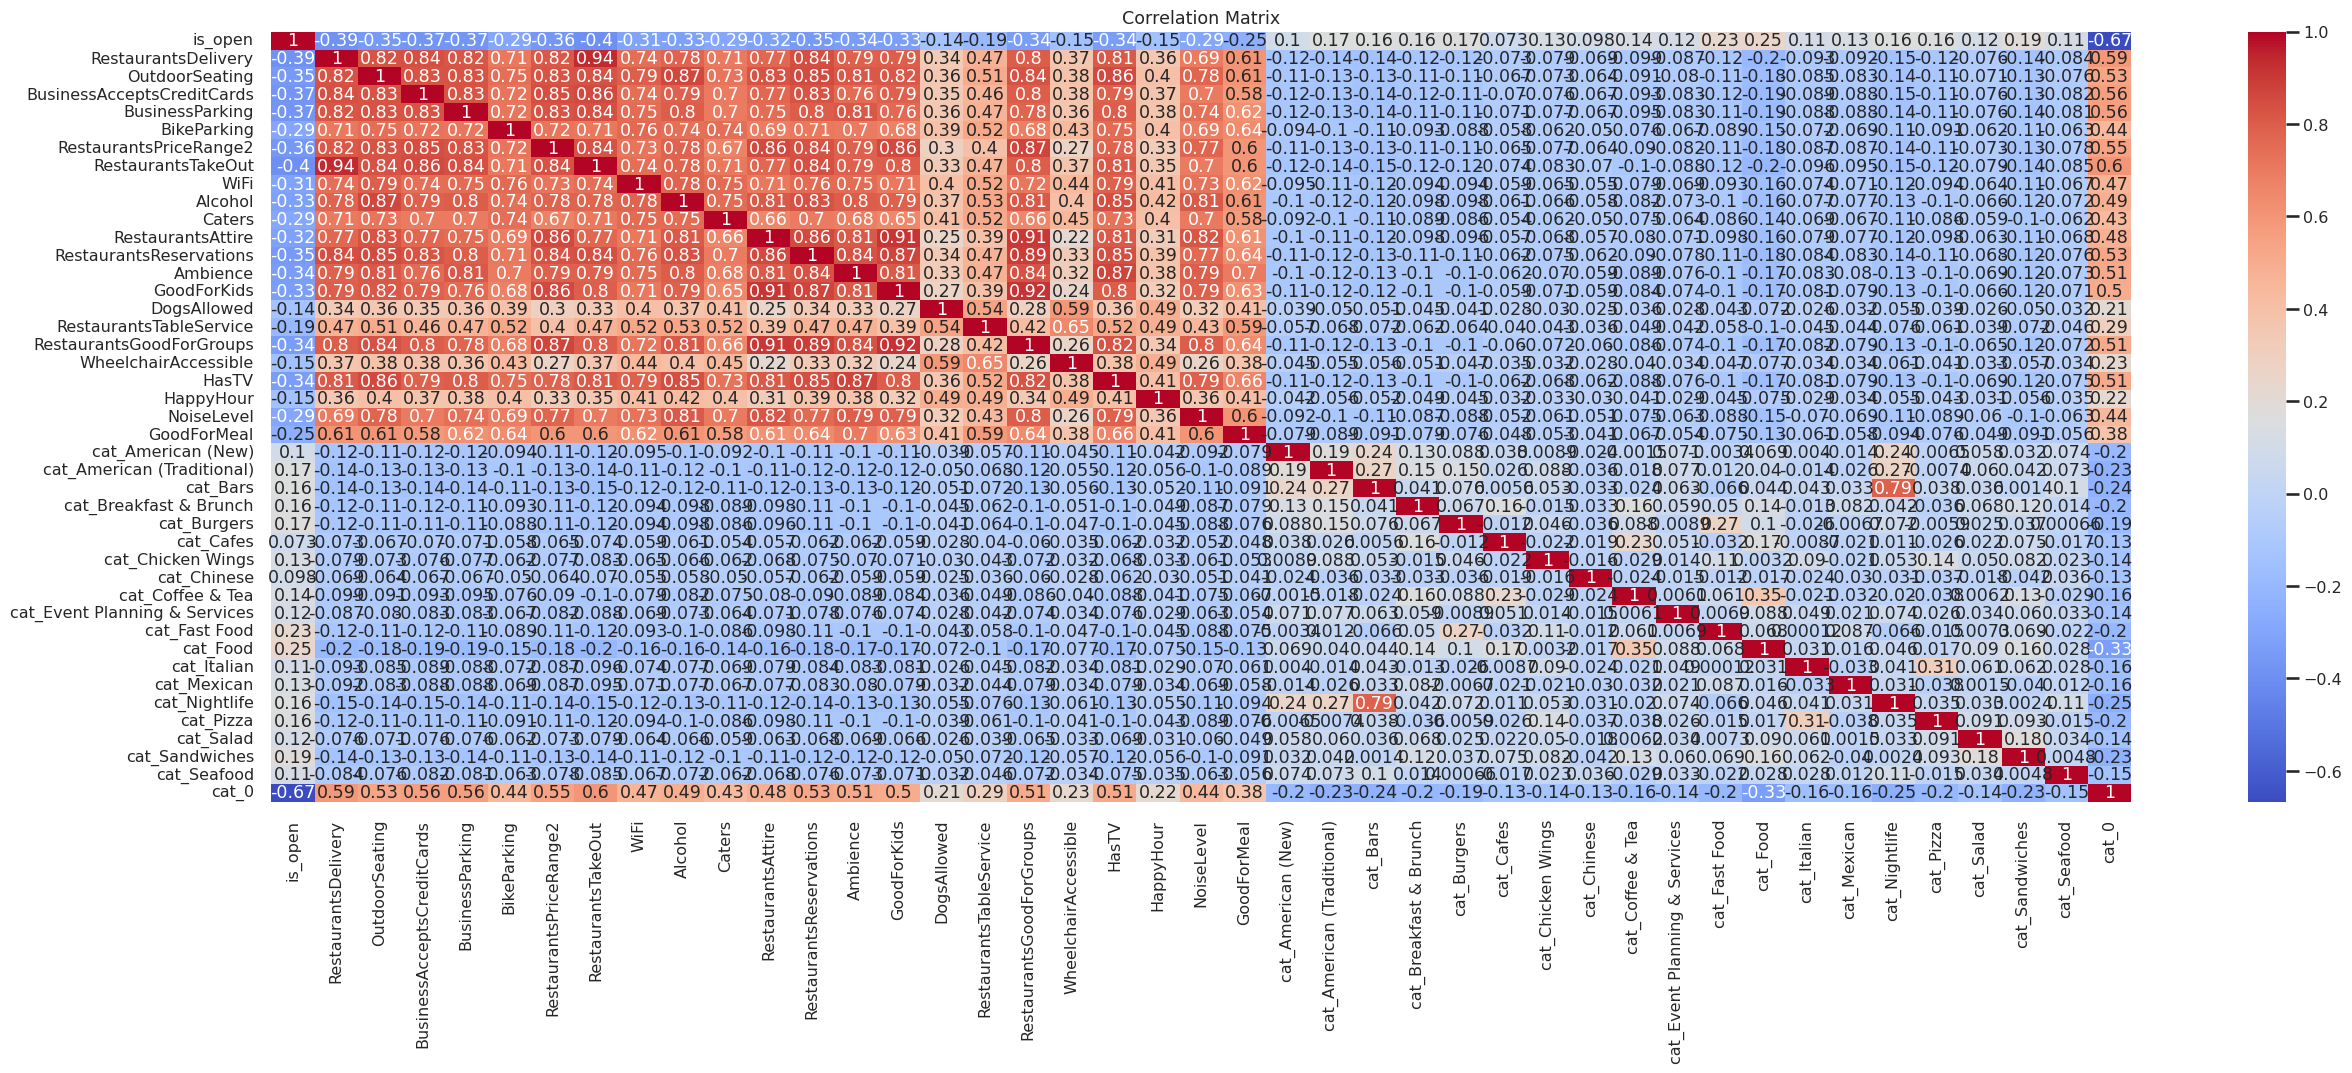

In [50]:
# Compute the correlation matrix
corr_matrix = business_normalized.corr()

# Identify highly correlated features
high_corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            high_corr_features.add(colname_i)
            high_corr_features.add(colname_j)

# Choose one feature from each correlated pair
selected_features = list(set(business_normalized.columns) - high_corr_features)

sns.heatmap(business_normalized.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [51]:
# Drop columns that are not in the list of selected features
business_normalized = business_normalized.drop(columns=set(business_normalized.columns) - set(selected_features))


In [52]:
business_normalized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86401 entries, 3 to 52262
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   city                           86401 non-null  object
 1   state                          86401 non-null  object
 2   postal_code                    86401 non-null  object
 3   is_open                        86401 non-null  int64 
 4   DogsAllowed                    86401 non-null  int64 
 5   RestaurantsTableService        86401 non-null  int64 
 6   WheelchairAccessible           86401 non-null  int64 
 7   HappyHour                      86401 non-null  int64 
 8   GoodForMeal                    86401 non-null  int64 
 9   cat_American (New)             86401 non-null  int64 
 10  cat_American (Traditional)     86401 non-null  int64 
 11  cat_Breakfast & Brunch         86401 non-null  int64 
 12  cat_Burgers                    86401 non-null  int64 
 13  c

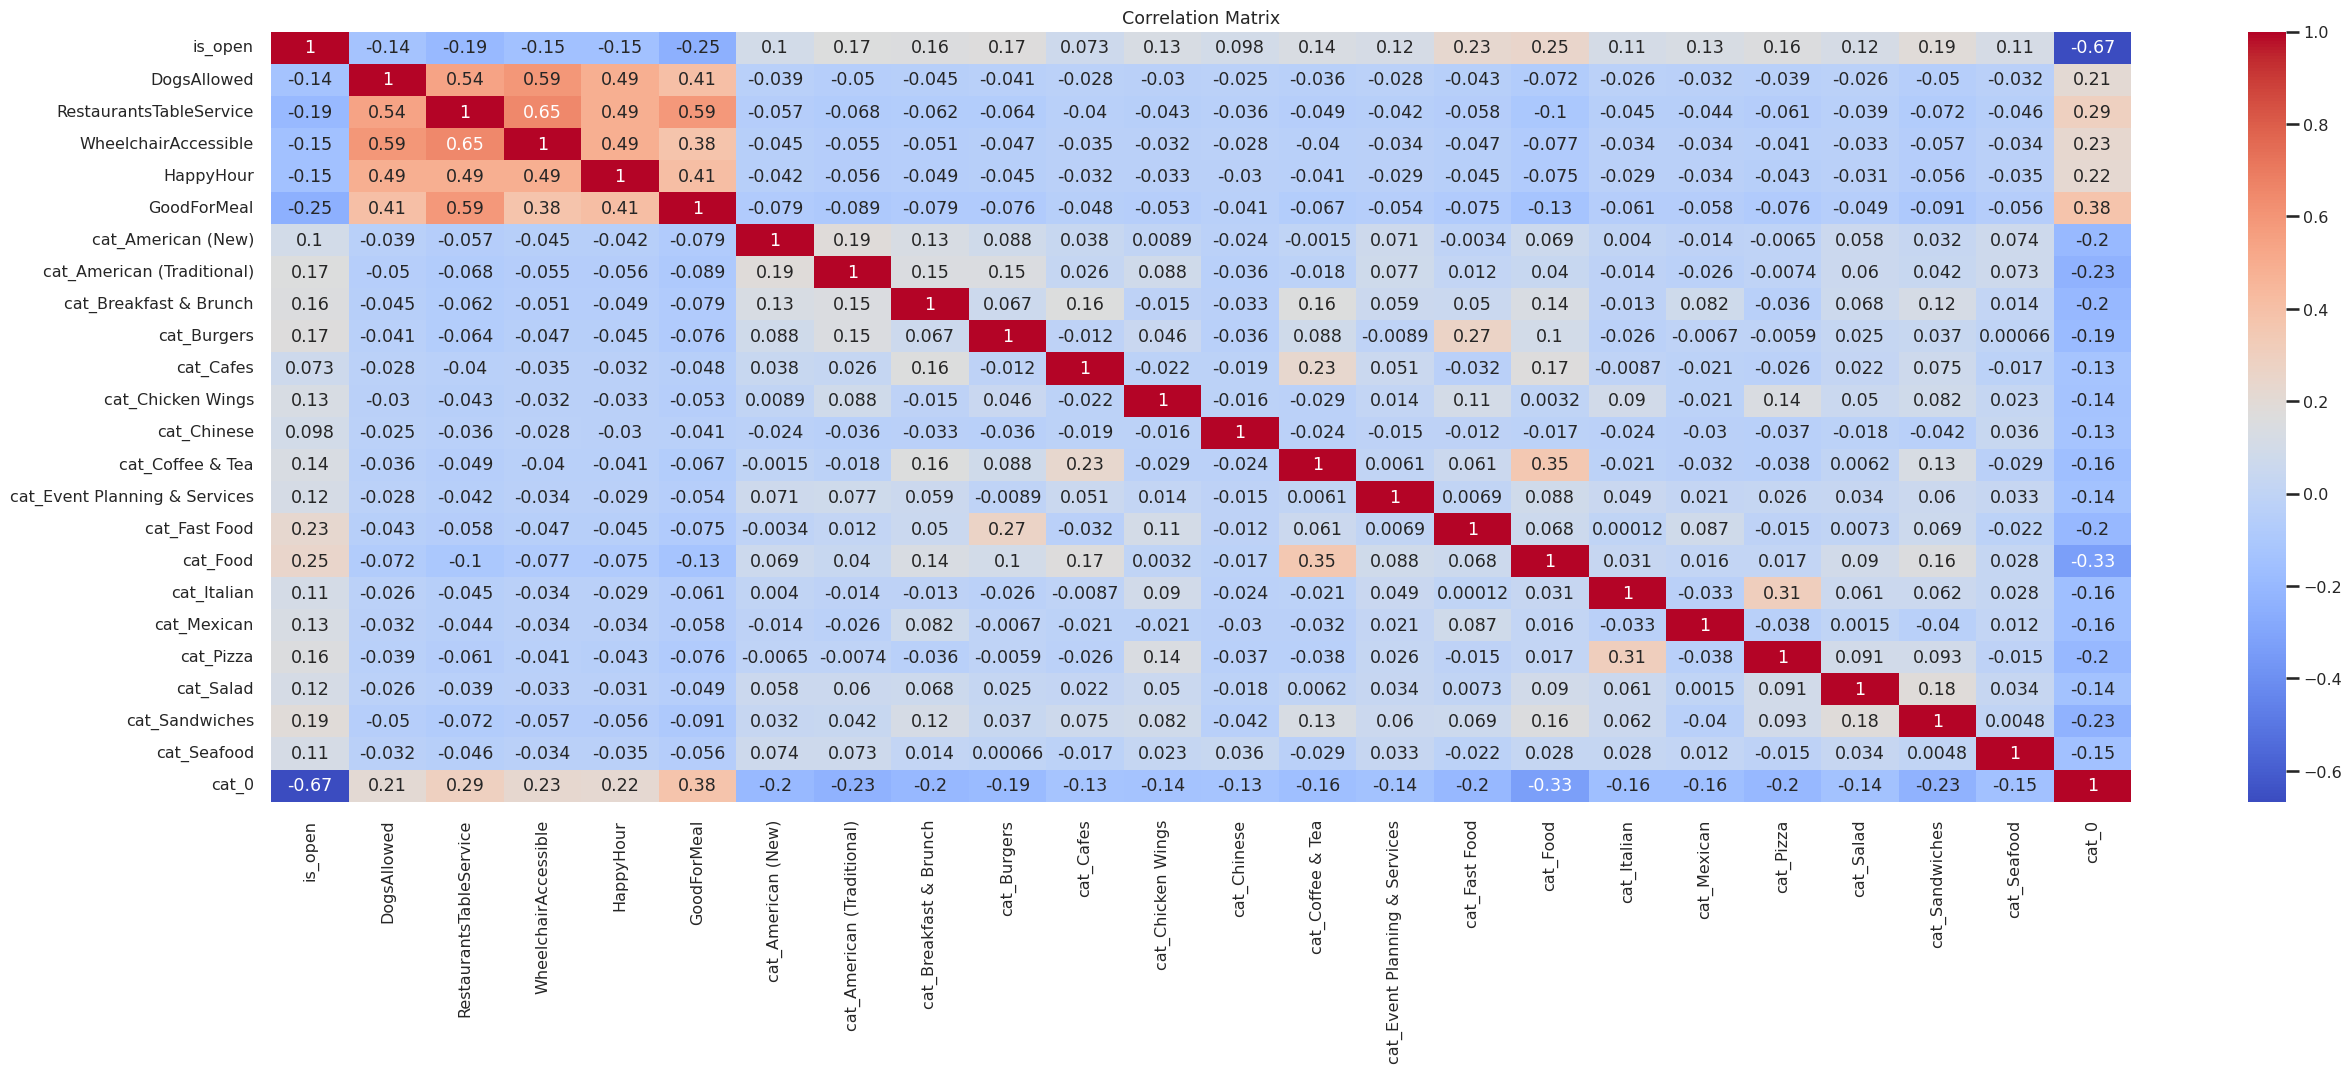

In [53]:
# Plot correlation matrix as heatmap
# plt.figure(figsize=(10, 8))
sns.heatmap(business_normalized.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [54]:
# Basic Data Cleaning
business_normalized.columns = business_normalized.columns.str.lower().str.replace(' ', '_') # A
 
string_columns = list(business_normalized.dtypes[business_normalized.dtypes == 'object'].index) # B
 
for col in string_columns:
    business_normalized[col] = business_normalized[col].astype(str).str.lower().str.replace(' ', '_')

In [55]:
business_normalized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86401 entries, 3 to 52262
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   city                           86401 non-null  object
 1   state                          86401 non-null  object
 2   postal_code                    86401 non-null  object
 3   is_open                        86401 non-null  int64 
 4   dogsallowed                    86401 non-null  int64 
 5   restaurantstableservice        86401 non-null  int64 
 6   wheelchairaccessible           86401 non-null  int64 
 7   happyhour                      86401 non-null  int64 
 8   goodformeal                    86401 non-null  int64 
 9   cat_american_(new)             86401 non-null  int64 
 10  cat_american_(traditional)     86401 non-null  int64 
 11  cat_breakfast_&_brunch         86401 non-null  int64 
 12  cat_burgers                    86401 non-null  int64 
 13  c

In [56]:
business_normalized.shape

(86401, 27)

In [57]:
business_normalized.head()

,city,state,postal_code,is_open,dogsallowed,restaurantstableservice,wheelchairaccessible,happyhour,goodformeal,cat_american_(new),cat_american_(traditional),cat_breakfast_&_brunch,cat_burgers,cat_cafes,cat_chicken_wings,cat_chinese,cat_coffee_&_tea,cat_event_planning_&_services,cat_fast_food,cat_food,cat_italian,cat_mexican,cat_pizza,cat_salad,cat_sandwiches,cat_seafood,cat_0
3,philadelphia,pa,19107,1,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
5,ashland_city,tn,37015,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
8,affton,mo,63123,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9,nashville,tn,37207,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0
11,tampa_bay,fl,33602,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [58]:
business_normalized.to_csv("business_normalized.csv")

In [59]:
# Pandas Profiler on business_normalized
profile = pp.ProfileReport(business_normalized)
profile.to_file("business_normalized_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

SQL Interface

In [60]:
# Create a SQLite connection in memory
conn = sqlite3.connect(':memory:')

# Write the data to a SQLite table
business_normalized.to_sql('business_normalized', conn, if_exists='replace', index=False)

86401

In [61]:
query = "SELECT * FROM business_normalized LIMIT 10;"


In [62]:
pd.read_sql_query(query,conn)

,city,state,postal_code,is_open,dogsallowed,restaurantstableservice,wheelchairaccessible,happyhour,goodformeal,cat_american_(new),cat_american_(traditional),cat_breakfast_&_brunch,cat_burgers,cat_cafes,cat_chicken_wings,cat_chinese,cat_coffee_&_tea,cat_event_planning_&_services,cat_fast_food,cat_food,cat_italian,cat_mexican,cat_pizza,cat_salad,cat_sandwiches,cat_seafood,cat_0
0,philadelphia,pa,19107,1,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
1,ashland_city,tn,37015,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
2,affton,mo,63123,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,nashville,tn,37207,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0
4,tampa_bay,fl,33602,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,indianapolis,in,46227,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,largo,fl,33771,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,philadelphia,pa,19106,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,philadelphia,pa,19147,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,edmonton,ab,t5j_1b9,0,0,1,1,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [63]:
def execute_query(query):
    result = pd.read_sql_query(query, conn)
    return result

def on_click(_):
    query = query_input.value
    try:
        result = execute_query(query)
        display(result)
    except Exception as e:
        print(f"Error: {e}")

In [64]:
query_input = widgets.Textarea(
    placeholder="Enter your SQL query here...",
    layout=widgets.Layout(width="80%", height="100px")
)

In [65]:
query_button = widgets.Button(
    description="Execute Query",
    button_style="info"
)
query_button.on_click(on_click)
display(query_input, query_button)

Textarea(value='', layout=Layout(height='100px', width='80%'), placeholder='Enter your SQL query here...')

Button(button_style='info', description='Execute Query', style=ButtonStyle())

# Machine Learning

## XGBoost

Call XGBoost BaseLine Classifier without Hyperparameter tuning

In [66]:
# Separate the features and the target variable

X = business_normalized.drop(['is_open'], axis=1)
y = business_normalized['is_open']

# Get all non-numerical columns and perform one-hot encoding
non_numeric_cols = list(X.select_dtypes(exclude=['number', 'bool']).columns)
one_hot_encoded = pd.get_dummies(X[non_numeric_cols])

# Combine one-hot encoded columns with numerical columns
numerical_cols = list(X.select_dtypes(include=['number', 'bool']).columns)
X = pd.concat([X[numerical_cols], one_hot_encoded], axis=1)


In [67]:
# Split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
# Init classifier
xgb_cl = xgb.XGBClassifier()

In [ ]:
# Fit
xgb_cl.fit(X_train, y_train)

In [ ]:
# Predict
y_pred = xgb_cl.predict(X_test)

In [ ]:
# Score
accuracy_score(y_test, y_pred)

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Open", "Is Open"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#calculating precision and reall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
 
print('Precision: ',precision)
print('Recall: ',recall)

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, xgb_cl.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

In [ ]:
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Feature Importance Plot with actual feature names
feature_importance = xgb_cl.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

In [ ]:
plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importance")
plt.show()


Conclusion: Stars is the most important feature to predict: Open/Not Open

Hyperparameter optimization using Bayesian Optimization with the XGBoost Classifier  model

In [ ]:
# Define function to compute cross-validated accuracy
def xgb_cv(n_estimators, max_depth, gamma, min_child_weight, subsample):
    model = xgb.XGBClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        gamma=gamma,
        min_child_weight=min_child_weight,
        subsample=subsample,
        random_state=42,
    )
    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy"))

In [ ]:
# Define function to optimize XGBoost classifier using Bayesian Optimization
def optimize_xgb():
    def xgb_crossval(n_estimators, max_depth, gamma, min_child_weight, subsample):
        return xgb_cv(n_estimators, max_depth, gamma, min_child_weight, subsample)

    optimizer = BayesianOptimization(
        f=xgb_crossval,
        pbounds={
            "n_estimators": (100, 500),
            "max_depth": (3, 10),
            "gamma": (0, 1),
            "min_child_weight": (1, 10),
            "subsample": (0.5, 1),
        },
        random_state=42,
    )
    optimizer.maximize(n_iter=10)
    return optimizer.max

In [ ]:
# Find optimal hyperparameters using Bayesian Optimization
best_params = optimize_xgb()['params']
print("Best hyperparameters found by Bayesian Optimization:", best_params)

In [ ]:
# Train the XGBoost classifier with the best hyperparameters
best_xgb = xgb.XGBClassifier(
    n_estimators=int(best_params["n_estimators"]),
    max_depth=int(best_params["max_depth"]),
    gamma=best_params["gamma"],
    min_child_weight=best_params["min_child_weight"],
    subsample=best_params["subsample"],
    random_state=42,
)

In [ ]:
best_xgb.fit(X_train, y_train)

In [ ]:
# Evaluate the model on the test set
y_pred = best_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:, 1])

In [ ]:
print("Test set accuracy with best hyperparameters:", accuracy)
print("Test set F1-score with best hyperparameters:", f1)
print("Test set ROC-AUC score with best hyperparameters:", roc_auc)

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Open", "Is Open"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#calculating precision and reall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
 
print('Precision: ',precision)
print('Recall: ',recall)

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, best_xgb.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

In [ ]:
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Feature Importance Plot with actual feature names
feature_importance = best_xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

In [ ]:
plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importance")
plt.show()

Optimized XGBoost Classifier with Bayesian Optimizer

Test set accuracy with best hyperparameters: 0.797986227648863

Test set F1-score with best hyperparameters: 0.7929050246188527

Test set ROC-AUC score with best hyperparameters: 0.8809630536439533

Stars is the most important feature to predict: Open/Not Open

## Neural Networks

Model: Neural Network

In [ ]:
#Separate features and target variables
X = business_normalized.drop(['is_open'], axis=1)
y = business_normalized['is_open']

# Get all non-numerical columns and perform one-hot encoding
non_numeric_cols = list(X.select_dtypes(exclude=['number', 'bool']).columns)
one_hot_encoded = pd.get_dummies(X[non_numeric_cols])

# Combine one-hot encoded columns with numerical columns
numerical_cols = list(X.select_dtypes(include=['number', 'bool']).columns)
X = pd.concat([X[numerical_cols], one_hot_encoded], axis=1)


In [ ]:
# Split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Build a NN
# First define the mode: 3 layers, 10 nodes in input layer, 8 in second layer, 3 in output layer
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(selected_features.shape[0],)))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(3, activation='softmax'))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit the model (train it)

model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=2)

In [ ]:
# Evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy: %.3f' % acc)

In [ ]:
#business_normalized[X_selected_columns].sample(1).columns
X_test.shape

In [ ]:
# Make a prediction
stars = 4
alcohol = 1
wifi = 1
has_tv = 1
good_for_groups = 1
accepts_credit_cards = 1
outdoor_seating = 0
delivery = 1
business_park = 1
reservations = 1
ambience = 0
restaurant_attire = 0
take_out = 0
price_range2 = 0
good_for_kids = 0
american_ct = 0
bars = 1
breakfast_brunch = 0
burgers = 0
chicken_wings = 0
coffee_tea = 0
event_services = 0
ct_fast_ct_food = 0 
ct_food = 0
mexican = 0
night_life = 0
pizza = 1
salad = 1
sandwiches = 1
fast_ct_food = 1



In [ ]:
#yhat = model.predict([row])
row = [stars, alcohol, wifi, has_tv, good_for_groups, accepts_credit_cards, outdoor_seating, delivery , business_park, reservations, ambience, restaurant_attire, take_out, price_range2, good_for_kids, american_ct, bars, breakfast_brunch, burgers, chicken_wings, coffee_tea, event_services, ct_fast_ct_food, ct_food, mexican, night_life, pizza, salad, sandwiches, fast_ct_food]
yhat = model.predict([row])
print('Predicted: %s (class=%d)' % (yhat, argmax(yhat)))


# Hyperparameter tuning